<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

# **MODERN DATA ARCHITECTURES**: **THE MONEYBALL PROJECT**

## How to find undervalued assets in the Football market - **Notebook 2 - PySpark MLIB**

We will build a regression model with the rating of players coming from first and second division. (Generally speaking, they are the only ones that have a rating score)

We will then predict with that model the ratings from Third divisions. Thus, we will identify the best players from third division that hold similar characteristics to the first and second, on a budget

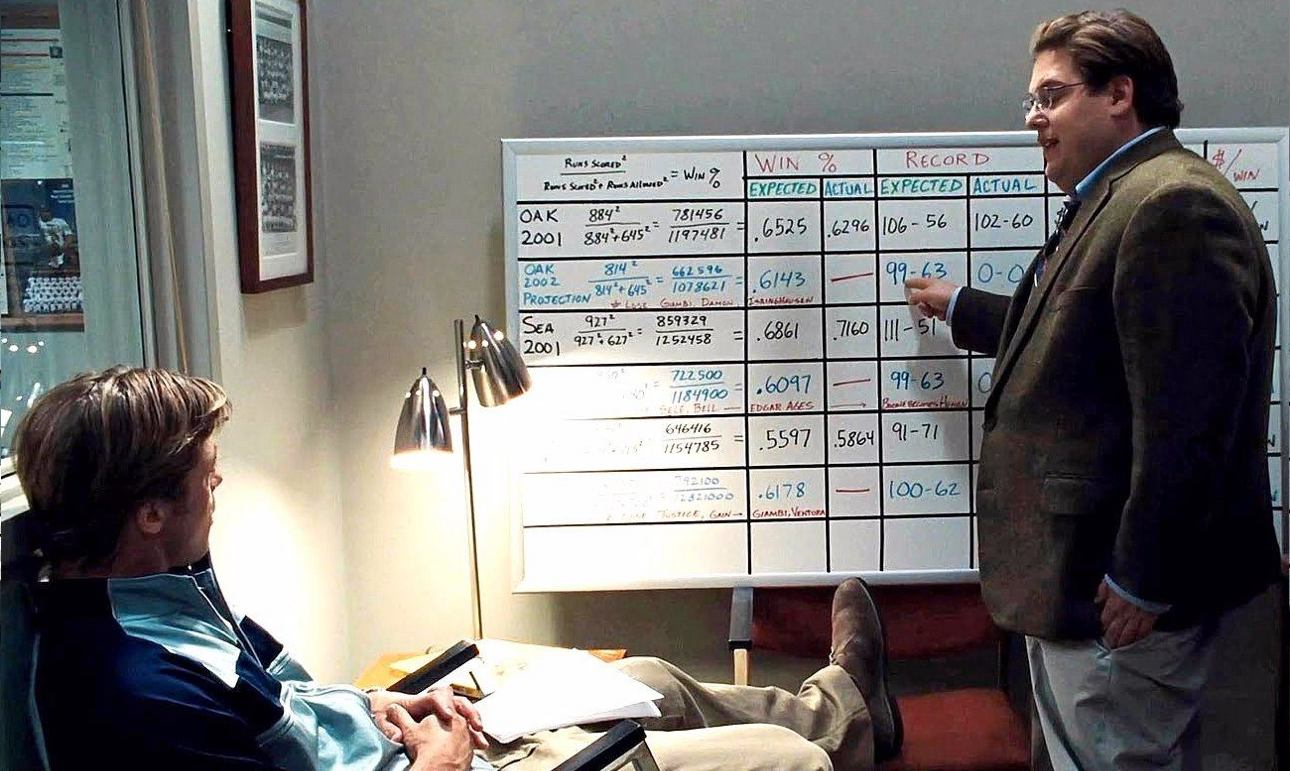

In [758]:
import findspark
from pyspark.sql.session import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

# Findspark will help Jupyter Notebook find Spark within OSBDET
findspark.init()

import pandas as pd

pd.set_option('display.max_colwidth', None)

In [759]:
spark_session = \
  SparkSession.builder\
              .appName("ML at scale with Spark - FootballPlayerValue")\
              .getOrCreate()

print(f"This cluster relies on Spark '{spark_session.version}'")

This cluster relies on Spark '3.5.1'


### **1. Reading the data**

In [760]:
FootballPlayerValue_df = spark_session.read\
                       .option("header", "true")\
                       .option("inferSchema", "true")\
                       .csv("hdfs://localhost:9000/datalake/raw/football/scouting/MergedModelling.csv")

In [761]:
FootballPlayerValue_df.printSchema()

root
 |-- player_id: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_firstname: string (nullable = true)
 |-- player_lastname: string (nullable = true)
 |-- player_age: double (nullable = true)
 |-- player_nationality: string (nullable = true)
 |-- player_height: double (nullable = true)
 |-- player_weight: double (nullable = true)
 |-- player_injured: boolean (nullable = true)
 |-- player_photo: string (nullable = true)
 |-- birth_date: date (nullable = true)
 |-- birth_place: string (nullable = true)
 |-- birth_country: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- logo: string (nullable = true)
 |-- country: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- appearences: double (nullable = true)
 |-- lineups: double (nullable = true)
 |-- minutes: double (nullable = true)
 |-- number: string (nullable = true)
 |-- position: string (nullable = 

### **2. Data Preparation**

In [762]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer


stringIndexer = StringIndexer(inputCol="player_nationality", outputCol="player_nationality_encoded")
model = stringIndexer.fit(FootballPlayerValue_df)
FootballPlayerValue_df = model.transform(FootballPlayerValue_df)

stringIndexer = StringIndexer(inputCol="position", outputCol="position_encoded")
model = stringIndexer.fit(FootballPlayerValue_df)
FootballPlayerValue_df = model.transform(FootballPlayerValue_df)

stringIndexer = StringIndexer(inputCol="Equipo", outputCol="team_name_encoded")
model = stringIndexer.fit(FootballPlayerValue_df)
FootballPlayerValue_df = model.transform(FootballPlayerValue_df)


stringIndexer = StringIndexer(inputCol="league", outputCol="league_encoded")
model = stringIndexer.fit(FootballPlayerValue_df)
FootballPlayerValue_df = model.transform(FootballPlayerValue_df)



FootballPlayerValue_df = FootballPlayerValue_df.withColumn("MarketValue", col("Valor de mercado").cast("integer"))

new_columns = [col.replace(".", "_") for col in FootballPlayerValue_df.columns]
FootballPlayerValue_df = FootballPlayerValue_df.toDF(*new_columns)


In [763]:
FootballPlayerValue_df.limit(10).toPandas()

,player_id,player_name,player_firstname,player_lastname,player_age,player_nationality,player_height,player_weight,player_injured,player_photo,...,Nacionalidades,Valor de mercado,matched_name,score,full_name_y,player_nationality_encoded,position_encoded,team_name_encoded,league_encoded,MarketValue
0,56,A. Griezmann,Antoine,Griezmann,33.0,France,176.0,73.0,False,https://media.api-sports.io/football/players/56.png,...,Francia,25000000,La Liga-Atletico Madrid-Antoine Griezmann,100,La Liga-Atletico Madrid-Antoine Griezmann,0.0,2.0,156.0,9.0,25000000
1,521,R. Lewandowski,Robert,Lewandowski,36.0,Poland,185.0,81.0,False,https://media.api-sports.io/football/players/521.png,...,Polonia,20000000,La Liga-Barcelona-Robert Lewandowski,100,La Liga-Barcelona-Robert Lewandowski,18.0,2.0,157.0,9.0,20000000
2,667,M. Depay,Memphis,Depay,30.0,Netherlands,178.0,78.0,False,https://media.api-sports.io/football/players/667.png,...,"Paises Bajos, Ghana",12000000,La Liga-Atletico Madrid-Memphis Depay,100,La Liga-Atletico Madrid-Memphis Depay,5.0,2.0,156.0,9.0,12000000
3,1094,D. Samassekou,Diadie,Samassekou,28.0,Mali,175.0,70.0,False,https://media.api-sports.io/football/players/1094.png,...,Mali,2500000,La Liga-Cadiz-Diadie Samassekou,100,La Liga-Cadiz-Diadie Samassekou,9.0,0.0,190.0,9.0,2500000
4,72048,C. Ozkacar,Cenk,Ozkacar,24.0,Turkiye,190.0,87.0,False,https://media.api-sports.io/football/players/72048.png,...,Turquia,2500000,La Liga-Valencia-Cenk Ozkacar,100,La Liga-Valencia-Cenk Ozkacar,22.0,1.0,154.0,9.0,2500000
5,288699,M. Perrone,Maximo,Perrone,21.0,Argentina,177.0,68.0,False,https://media.api-sports.io/football/players/288699.png,...,"Argentina, Espana",7500000,La Liga-Las Palmas-Maximo Perrone,100,La Liga-Las Palmas-Maximo Perrone,15.0,0.0,180.0,9.0,7500000
6,312650,Marezi,Marko,Milovanovic,21.0,Serbia,196.0,85.0,False,https://media.api-sports.io/football/players/312650.png,...,Serbia,1000000,La Liga-Almeria-Marko Milovanovic,100,La Liga-Almeria-Marko Milovanovic,7.0,2.0,140.0,9.0,1000000
7,1117,K. Tierney,Kieran,Tierney,27.0,Scotland,178.0,70.0,False,https://media.api-sports.io/football/players/1117.png,...,"Escocia, Isla de Man",18000000,La Liga-Real Sociedad-Kieran Tierney,100,La Liga-Real Sociedad-Kieran Tierney,14.0,1.0,172.0,9.0,18000000
8,2202,H. Traore,Hamari,Traore,32.0,Mali,175.0,64.0,False,https://media.api-sports.io/football/players/2202.png,...,Mali,9000000,La Liga-Real Sociedad-Hamari Traore,100,La Liga-Real Sociedad-Hamari Traore,9.0,1.0,172.0,9.0,9000000
9,32862,T. Kubo,Takefusa,Kubo,23.0,Japan,173.0,64.0,False,https://media.api-sports.io/football/players/32862.png,...,Japon,60000000,La Liga-Real Sociedad-Takefusa Kubo,100,La Liga-Real Sociedad-Takefusa Kubo,11.0,0.0,172.0,9.0,60000000


In [764]:
#Filtering by leagues with statistics
leagues = [
    "La Liga", "Segunda Division", "Serie A", "Serie B", "Premier League", 
    "Championship League", "Bundesliga 1", "Bundesliga 2", "Ligue 1", "Ligue 2"
]

# Filter the DataFrame
FootballPlayerValue_df = FootballPlayerValue_df.filter(col("league").isin(leagues))

In [765]:
FootballPlayerValue_df.count()

PositionPlayerValue = FootballPlayerValue_df

In [766]:
FootballPlayerValue_df = FootballPlayerValue_df.na.fill(0)


### **3. First (horrible) model**

In [767]:
from pyspark.ml.feature import VectorAssembler # let's put everything in one vector

assembler = VectorAssembler(inputCols=["player_age", "player_nationality_encoded", "player_height", "player_weight", "player_injured", "appearences", "lineups", "minutes", "position_encoded", "captain", "substitutes_in", "substitutes_out", "substitutes_bench",
                                    "shots_total", "shots_on", "goals_total", "goals_conceded", "goals_assists", "goals_saves", "passes_total", "passes_key", "passes_accuracy", "tackles_total", "tackles_blocks", "tackles_interceptions", 
                                    "team_name_encoded", "duels_total", "duels_won", "dribbles_attempts", "dribbles_success", "fouls_drawn", "fouls_committed", "cards_yellow", "cards_yellowred", "cards_red",
                                    "penalty_scored", "penalty_missed", "penalty_saved", "division", "league_encoded"], outputCol="features", handleInvalid = "keep")

FootballFeatures_df = assembler.transform(FootballPlayerValue_df)
FootballFeatures_df.limit(1).toPandas()

,player_id,player_name,player_firstname,player_lastname,player_age,player_nationality,player_height,player_weight,player_injured,player_photo,...,Valor de mercado,matched_name,score,full_name_y,player_nationality_encoded,position_encoded,team_name_encoded,league_encoded,MarketValue,features
0,56,A. Griezmann,Antoine,Griezmann,33.0,France,176.0,73.0,False,https://media.api-sports.io/football/players/56.png,...,25000000,La Liga-Atletico Madrid-Antoine Griezmann,100,La Liga-Atletico Madrid-Antoine Griezmann,0.0,2.0,156.0,9.0,25000000,"[33.0, 0.0, 176.0, 73.0, 0.0, 24.0, 23.0, 1953.0, 2.0, 0.0, 1.0, 8.0, 2.0, 42.0, 27.0, 11.0, 0.0, 6.0, 0.0, 925.0, 35.0, 32.0, 24.0, 2.0, 9.0, 156.0, 154.0, 72.0, 34.0, 22.0, 17.0, 10.0, 3.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 9.0]"


In [768]:

(train_data, test_data) = FootballFeatures_df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="MarketValue")
lr_model = lr.fit(train_data)



24/03/14 12:23:09 WARN Instrumentation: [583e300a] regParam is zero, which might cause numerical instability and overfitting.
24/03/14 12:23:09 WARN Instrumentation: [583e300a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [769]:
predictions = lr_model.transform(test_data)


In [770]:
predictions.select("player_name","features", "MarketValue", "prediction").show(5)


+-----------+--------------------+-----------+--------------------+
|player_name|            features|MarketValue|          prediction|
+-----------+--------------------+-----------+--------------------+
|   M. Gotze|[32.0,1.0,176.0,7...|    7000000|1.1025651308387494E7|
|    M. Wolf|[29.0,1.0,188.0,8...|    6500000|   8092254.159826346|
|   S. Savic|[33.0,35.0,187.0,...|    5000000|1.0353378110646496E7|
|  C. Ngonge|[24.0,12.0,179.0,...|   12000000|  1.53593943241473E7|
|P. Pellegri|[23.0,2.0,196.0,7...|    3500000|  3555167.4731214326|
+-----------+--------------------+-----------+--------------------+
only showing top 5 rows



In [771]:
evaluator = RegressionEvaluator(labelCol="MarketValue", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)


Root Mean Squared Error (RMSE) on test data = 10276004.063226413


### **4. Position Models**

This is not a good model with a lot of RMSE deviation, we will make models by position now, specialising in the stats. 

When talking money and market value, people go nuts and MarketValues might not follow a linear model but an exponential one. To not overcomplicate this exercise... we will focus on Rating, an internal rating from API-football.com (that is scaled from 0-10 points) and we will compare it with the prediction. After that we will know which goalies are under or over valued and we will know what to pay 

#### 4.1 Goalies

In [772]:
GoalieFeatures_df = PositionPlayerValue.filter(col("position") == "Goalkeeper")
GoalieFeatures_df = GoalieFeatures_df.na.fill(0)


GoalieFeatures_df.limit(5).toPandas()

,player_id,player_name,player_firstname,player_lastname,player_age,player_nationality,player_height,player_weight,player_injured,player_photo,...,Nacionalidades,Valor de mercado,matched_name,score,full_name_y,player_nationality_encoded,position_encoded,team_name_encoded,league_encoded,MarketValue
0,2814,P. Rajkovic,Predrag,Rajkovic,29.0,Serbia,191.0,86.0,False,https://media.api-sports.io/football/players/2814.png,...,Serbia,10000000,La Liga-Mallorca-Predrag Rajkovic,100,La Liga-Mallorca-Predrag Rajkovic,7.0,3.0,132.0,9.0,10000000
1,29,J. Oblak,Jan,Oblak,31.0,Slovenia,188.0,87.0,False,https://media.api-sports.io/football/players/29.png,...,Eslovenia,35000000,La Liga-Atletico Madrid-Jan Oblak,100,La Liga-Atletico Madrid-Jan Oblak,47.0,3.0,156.0,9.0,35000000
2,127,M. ter Stegen,Marc-Andre,ter Stegen,32.0,Germany,187.0,85.0,False,https://media.api-sports.io/football/players/127.png,...,Alemania,35000000,La Liga-Barcelona-Marc-Andre ter Stegen,100,La Liga-Barcelona-Marc-Andre ter Stegen,1.0,3.0,157.0,9.0,35000000
3,47527,S. Dimitrievski,Stole,Dimitrievski,31.0,North Macedonia,188.0,84.0,False,https://media.api-sports.io/football/players/47527.png,...,"Macedonia del Norte, Espana",4000000,La Liga-Rayo Vallecano-Stole Dimitrievski,100,La Liga-Rayo Vallecano-Stole Dimitrievski,55.0,3.0,203.0,9.0,4000000
4,24760,G. Mamardashvili,Giorgi,Mamardashvili,24.0,Georgia,199.0,86.0,False,https://media.api-sports.io/football/players/24760.png,...,Georgia,30000000,La Liga-Valencia-Giorgi Mamardashvili,100,La Liga-Valencia-Giorgi Mamardashvili,33.0,3.0,154.0,9.0,30000000


In [773]:
assembler = VectorAssembler(inputCols=["player_age","player_height", "player_weight", "player_injured","minutes",
                                       "captain", "goals_saves","penalty_saved"], outputCol="goalie_features")

GoalieFeatures_df = assembler.transform(GoalieFeatures_df)
GoalieFeatures_df.limit(5).toPandas()

,player_id,player_name,player_firstname,player_lastname,player_age,player_nationality,player_height,player_weight,player_injured,player_photo,...,Valor de mercado,matched_name,score,full_name_y,player_nationality_encoded,position_encoded,team_name_encoded,league_encoded,MarketValue,goalie_features
0,2814,P. Rajkovic,Predrag,Rajkovic,29.0,Serbia,191.0,86.0,False,https://media.api-sports.io/football/players/2814.png,...,10000000,La Liga-Mallorca-Predrag Rajkovic,100,La Liga-Mallorca-Predrag Rajkovic,7.0,3.0,132.0,9.0,10000000,"[29.0, 191.0, 86.0, 0.0, 2520.0, 0.0, 77.0, 0.0]"
1,29,J. Oblak,Jan,Oblak,31.0,Slovenia,188.0,87.0,False,https://media.api-sports.io/football/players/29.png,...,35000000,La Liga-Atletico Madrid-Jan Oblak,100,La Liga-Atletico Madrid-Jan Oblak,47.0,3.0,156.0,9.0,35000000,"[31.0, 188.0, 87.0, 0.0, 2520.0, 0.0, 81.0, 0.0]"
2,127,M. ter Stegen,Marc-Andre,ter Stegen,32.0,Germany,187.0,85.0,False,https://media.api-sports.io/football/players/127.png,...,35000000,La Liga-Barcelona-Marc-Andre ter Stegen,100,La Liga-Barcelona-Marc-Andre ter Stegen,1.0,3.0,157.0,9.0,35000000,"[32.0, 187.0, 85.0, 0.0, 1620.0, 0.0, 46.0, 0.0]"
3,47527,S. Dimitrievski,Stole,Dimitrievski,31.0,North Macedonia,188.0,84.0,False,https://media.api-sports.io/football/players/47527.png,...,4000000,La Liga-Rayo Vallecano-Stole Dimitrievski,100,La Liga-Rayo Vallecano-Stole Dimitrievski,55.0,3.0,203.0,9.0,4000000,"[31.0, 188.0, 84.0, 0.0, 2520.0, 0.0, 92.0, 0.0]"
4,24760,G. Mamardashvili,Giorgi,Mamardashvili,24.0,Georgia,199.0,86.0,False,https://media.api-sports.io/football/players/24760.png,...,30000000,La Liga-Valencia-Giorgi Mamardashvili,100,La Liga-Valencia-Giorgi Mamardashvili,33.0,3.0,154.0,9.0,30000000,"[24.0, 199.0, 86.0, 0.0, 2430.0, 0.0, 78.0, 0.0]"


In [774]:

(train_data, test_data) = GoalieFeatures_df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="goalie_features", labelCol="rating")
gk_lr_model = lr.fit(train_data)



24/03/14 12:23:10 WARN Instrumentation: [5e5e4ed5] regParam is zero, which might cause numerical instability and overfitting.
24/03/14 12:23:10 WARN Instrumentation: [5e5e4ed5] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [775]:
predictions_gk = gk_lr_model.transform(test_data)
predictions_gk.select("player_name","goalie_features", "rating", "prediction", "MarketValue").show()


+---------------+--------------------+--------+-----------------+-----------+
|    player_name|     goalie_features|  rating|       prediction|MarketValue|
+---------------+--------------------+--------+-----------------+-----------+
|      S. Cibois|[26.0,192.0,83.0,...|    6.92|6.960305177682179|     300000|
|     S. Ulreich|[36.0,192.0,87.0,...|  6.5875|6.782467334912061|     700000|
| O. Vlachodimos|[30.0,188.0,78.0,...|    6.64|6.926008306458797|   10000000|
|       M. Perin|[32.0,188.0,85.0,...|    6.95|6.892361516279586|    3000000|
|  G. Donnarumma|[25.0,196.0,90.0,...|7.161904|7.122605366110584|   40000000|
|       J. Omlin|[30.0,190.0,80.0,...|    7.45|7.007993298469368|    9000000|
|     M. Samassa|[34.0,198.0,85.0,...|   7.152|6.830597771667527|     250000|
|   I. Filipovic|[30.0,197.0,92.0,...|6.811111|6.908689668792867|     400000|
|      B. Wilson|[32.0,186.0,70.0,...|6.794444|6.862330916340092|     800000|
|       J. Fabri|[30.0,183.0,75.0,...|    6.95|7.008934353310915

It is very simplistic but honestly, accurate enough! With this model, we can ingest players that have not been seen before and give a rating to them

#### 4.2 Attackers

In [776]:
AttackerFeatures_df = PositionPlayerValue.filter(col("position") == "Attacker")
AttackerFeatures_df = AttackerFeatures_df.na.fill(0)


AttackerFeatures_df.limit(5).toPandas()

,player_id,player_name,player_firstname,player_lastname,player_age,player_nationality,player_height,player_weight,player_injured,player_photo,...,Nacionalidades,Valor de mercado,matched_name,score,full_name_y,player_nationality_encoded,position_encoded,team_name_encoded,league_encoded,MarketValue
0,56,A. Griezmann,Antoine,Griezmann,33.0,France,176.0,73.0,False,https://media.api-sports.io/football/players/56.png,...,Francia,25000000,La Liga-Atletico Madrid-Antoine Griezmann,100,La Liga-Atletico Madrid-Antoine Griezmann,0.0,2.0,156.0,9.0,25000000
1,521,R. Lewandowski,Robert,Lewandowski,36.0,Poland,185.0,81.0,False,https://media.api-sports.io/football/players/521.png,...,Polonia,20000000,La Liga-Barcelona-Robert Lewandowski,100,La Liga-Barcelona-Robert Lewandowski,18.0,2.0,157.0,9.0,20000000
2,667,M. Depay,Memphis,Depay,30.0,Netherlands,178.0,78.0,False,https://media.api-sports.io/football/players/667.png,...,"Paises Bajos, Ghana",12000000,La Liga-Atletico Madrid-Memphis Depay,100,La Liga-Atletico Madrid-Memphis Depay,5.0,2.0,156.0,9.0,12000000
3,312650,Marezi,Marko,Milovanovic,21.0,Serbia,196.0,85.0,False,https://media.api-sports.io/football/players/312650.png,...,Serbia,1000000,La Liga-Almeria-Marko Milovanovic,100,La Liga-Almeria-Marko Milovanovic,7.0,2.0,140.0,9.0,1000000
4,3033,C. Bakambu,Cedric,Bakambu,33.0,Congo DR,182.0,73.0,False,https://media.api-sports.io/football/players/3033.png,...,"RD del Congo, Francia",2800000,La Liga-Real Betis-Cedric Bakambu,100,La Liga-Real Betis-Cedric Bakambu,53.0,2.0,151.0,9.0,2800000


In [777]:
assembler = VectorAssembler(inputCols=["player_age", "player_height", "player_weight", "player_injured", "minutes", "captain", 
                                    "shots_total", "shots_on", "goals_total", "goals_assists", "passes_total", "passes_key",
                                    "duels_won", "dribbles_attempts", "dribbles_success", "fouls_drawn", "cards_yellow", "cards_red",
                                    "penalty_scored", "penalty_missed"], outputCol="attacker_features")

AttackerFeatures_df = assembler.transform(AttackerFeatures_df)
AttackerFeatures_df.limit(5).toPandas()

,player_id,player_name,player_firstname,player_lastname,player_age,player_nationality,player_height,player_weight,player_injured,player_photo,...,Valor de mercado,matched_name,score,full_name_y,player_nationality_encoded,position_encoded,team_name_encoded,league_encoded,MarketValue,attacker_features
0,56,A. Griezmann,Antoine,Griezmann,33.0,France,176.0,73.0,False,https://media.api-sports.io/football/players/56.png,...,25000000,La Liga-Atletico Madrid-Antoine Griezmann,100,La Liga-Atletico Madrid-Antoine Griezmann,0.0,2.0,156.0,9.0,25000000,"[33.0, 176.0, 73.0, 0.0, 1953.0, 0.0, 42.0, 27.0, 11.0, 6.0, 925.0, 35.0, 72.0, 34.0, 22.0, 17.0, 3.0, 0.0, 3.0, 0.0]"
1,521,R. Lewandowski,Robert,Lewandowski,36.0,Poland,185.0,81.0,False,https://media.api-sports.io/football/players/521.png,...,20000000,La Liga-Barcelona-Robert Lewandowski,100,La Liga-Barcelona-Robert Lewandowski,18.0,2.0,157.0,9.0,20000000,"[36.0, 185.0, 81.0, 0.0, 2040.0, 0.0, 50.0, 31.0, 12.0, 5.0, 407.0, 20.0, 102.0, 38.0, 16.0, 41.0, 4.0, 0.0, 3.0, 0.0]"
2,667,M. Depay,Memphis,Depay,30.0,Netherlands,178.0,78.0,False,https://media.api-sports.io/football/players/667.png,...,12000000,La Liga-Atletico Madrid-Memphis Depay,100,La Liga-Atletico Madrid-Memphis Depay,5.0,2.0,156.0,9.0,12000000,"[30.0, 178.0, 78.0, 0.0, 729.0, 0.0, 27.0, 13.0, 5.0, 1.0, 203.0, 11.0, 35.0, 25.0, 13.0, 13.0, 2.0, 0.0, 0.0, 0.0]"
3,312650,Marezi,Marko,Milovanovic,21.0,Serbia,196.0,85.0,False,https://media.api-sports.io/football/players/312650.png,...,1000000,La Liga-Almeria-Marko Milovanovic,100,La Liga-Almeria-Marko Milovanovic,7.0,2.0,140.0,9.0,1000000,"(21.0, 196.0, 85.0, 0.0, 225.0, 0.0, 3.0, 0.0, 1.0, 0.0, 49.0, 2.0, 13.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0)"
4,3033,C. Bakambu,Cedric,Bakambu,33.0,Congo DR,182.0,73.0,False,https://media.api-sports.io/football/players/3033.png,...,2800000,La Liga-Real Betis-Cedric Bakambu,100,La Liga-Real Betis-Cedric Bakambu,53.0,2.0,151.0,9.0,2800000,"(33.0, 182.0, 73.0, 0.0, 24.0, 0.0, 1.0, 0.0, 0.0, 0.0, 5.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [778]:

(train_data, test_data) = AttackerFeatures_df.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression(featuresCol="attacker_features", labelCol="rating")
attacker_lr_model = lr.fit(train_data)


24/03/14 12:23:11 WARN Instrumentation: [8e8c8e30] regParam is zero, which might cause numerical instability and overfitting.
24/03/14 12:23:11 WARN Instrumentation: [8e8c8e30] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [779]:
predictions_atk = attacker_lr_model.transform(test_data)
predictions_atk.select("player_name","team_name", "attacker_features", "rating", "prediction", "MarketValue").show()


+-------------+-------------------+--------------------+--------+------------------+-----------+
|  player_name|          team_name|   attacker_features|  rating|        prediction|MarketValue|
+-------------+-------------------+--------------------+--------+------------------+-----------+
|    C. Ngonge|             Napoli|[24.0,179.0,73.0,...|6.994736| 7.998373205552331|   12000000|
| Z. Aboukhlal|           Toulouse|[24.0,179.0,74.0,...|    6.78| 6.651434850256528|   10000000|
|     D. Malen|  Borussia Dortmund|[25.0,176.0,68.0,...| 7.35238| 7.251898869779188|   35000000|
|     Y. Akgun|          Leicester|[24.0,173.0,65.0,...|6.823529|   6.6683909101504|    5000000|
|   M. Solomon|          Tottenham|[25.0,170.0,66.0,...|    7.18| 6.626824151776777|   18000000|
|   K. Volland|       Union Berlin|[32.0,174.0,85.0,...| 6.80625|  6.17777490140828|    5000000|
|    S. Azmoun|            AS Roma|[29.0,187.0,80.0,...|    6.76|6.6201071231302056|   10000000|
|  L. Trossard|            Ars

#### 4.3 Midfielders

In [780]:
MidfieldFeatures_df = PositionPlayerValue.filter(col("position") == "Midfielder")
MidfieldFeatures_df = MidfieldFeatures_df.na.fill(0)


MidfieldFeatures_df.limit(5).toPandas()

,player_id,player_name,player_firstname,player_lastname,player_age,player_nationality,player_height,player_weight,player_injured,player_photo,...,Nacionalidades,Valor de mercado,matched_name,score,full_name_y,player_nationality_encoded,position_encoded,team_name_encoded,league_encoded,MarketValue
0,1094,D. Samassekou,Diadie,Samassekou,28.0,Mali,175.0,70.0,False,https://media.api-sports.io/football/players/1094.png,...,Mali,2500000,La Liga-Cadiz-Diadie Samassekou,100,La Liga-Cadiz-Diadie Samassekou,9.0,0.0,190.0,9.0,2500000
1,288699,M. Perrone,Maximo,Perrone,21.0,Argentina,177.0,68.0,False,https://media.api-sports.io/football/players/288699.png,...,"Argentina, Espana",7500000,La Liga-Las Palmas-Maximo Perrone,100,La Liga-Las Palmas-Maximo Perrone,15.0,0.0,180.0,9.0,7500000
2,32862,T. Kubo,Takefusa,Kubo,23.0,Japan,173.0,64.0,False,https://media.api-sports.io/football/players/32862.png,...,Japon,60000000,La Liga-Real Sociedad-Takefusa Kubo,100,La Liga-Real Sociedad-Takefusa Kubo,11.0,0.0,172.0,9.0,60000000
3,268960,A. Zakharyan,Arsen,Zakharyan,21.0,Russia,180.0,68.0,False,https://media.api-sports.io/football/players/268960.png,...,Rusia,15000000,La Liga-Real Sociedad-Arsen Zakharyan,100,La Liga-Real Sociedad-Arsen Zakharyan,46.0,0.0,172.0,9.0,15000000
4,1920,N. Radonjic,Nemanja,Radonjic,28.0,Serbia,185.0,78.0,False,https://media.api-sports.io/football/players/1920.png,...,Serbia,3000000,La Liga-Mallorca-Nemanja Radonjic,100,La Liga-Mallorca-Nemanja Radonjic,7.0,0.0,132.0,9.0,3000000


In [781]:
assembler = VectorAssembler(inputCols=["player_age", "player_height", "player_weight", "player_injured","minutes", "captain",
                                    "shots_total", "shots_on", "goals_total", "goals_assists", "passes_total", "passes_key", "passes_accuracy", "tackles_total", "tackles_blocks", "tackles_interceptions", 
                                    "duels_total", "duels_won", "dribbles_attempts", "dribbles_success", "fouls_drawn", "fouls_committed", "cards_yellow", "cards_yellowred", "cards_red",
                                    "penalty_scored", "penalty_missed"], outputCol="midfielder_features")

MidfieldFeatures_df = assembler.transform(MidfieldFeatures_df)
MidfieldFeatures_df.limit(5).toPandas()

,player_id,player_name,player_firstname,player_lastname,player_age,player_nationality,player_height,player_weight,player_injured,player_photo,...,Valor de mercado,matched_name,score,full_name_y,player_nationality_encoded,position_encoded,team_name_encoded,league_encoded,MarketValue,midfielder_features
0,1094,D. Samassekou,Diadie,Samassekou,28.0,Mali,175.0,70.0,False,https://media.api-sports.io/football/players/1094.png,...,2500000,La Liga-Cadiz-Diadie Samassekou,100,La Liga-Cadiz-Diadie Samassekou,9.0,0.0,190.0,9.0,2500000,"(28.0, 175.0, 70.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 1.0, 12.0, 2.0, 0.0, 2.0, 7.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
1,288699,M. Perrone,Maximo,Perrone,21.0,Argentina,177.0,68.0,False,https://media.api-sports.io/football/players/288699.png,...,7500000,La Liga-Las Palmas-Maximo Perrone,100,La Liga-Las Palmas-Maximo Perrone,15.0,0.0,180.0,9.0,7500000,"[21.0, 177.0, 68.0, 0.0, 1278.0, 0.0, 5.0, 1.0, 0.0, 0.0, 1059.0, 8.0, 41.0, 36.0, 3.0, 24.0, 146.0, 62.0, 17.0, 9.0, 11.0, 23.0, 5.0, 0.0, 0.0, 0.0, 0.0]"
2,32862,T. Kubo,Takefusa,Kubo,23.0,Japan,173.0,64.0,False,https://media.api-sports.io/football/players/32862.png,...,60000000,La Liga-Real Sociedad-Takefusa Kubo,100,La Liga-Real Sociedad-Takefusa Kubo,11.0,0.0,172.0,9.0,60000000,"[23.0, 173.0, 64.0, 0.0, 1687.0, 0.0, 31.0, 18.0, 7.0, 3.0, 528.0, 45.0, 20.0, 19.0, 2.0, 8.0, 201.0, 110.0, 73.0, 42.0, 42.0, 16.0, 2.0, 0.0, 0.0, 0.0, 0.0]"
3,268960,A. Zakharyan,Arsen,Zakharyan,21.0,Russia,180.0,68.0,False,https://media.api-sports.io/football/players/268960.png,...,15000000,La Liga-Real Sociedad-Arsen Zakharyan,100,La Liga-Real Sociedad-Arsen Zakharyan,46.0,0.0,172.0,9.0,15000000,"[21.0, 180.0, 68.0, 0.0, 775.0, 0.0, 16.0, 5.0, 0.0, 1.0, 279.0, 15.0, 10.0, 15.0, 0.0, 1.0, 94.0, 40.0, 22.0, 7.0, 8.0, 13.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
4,1920,N. Radonjic,Nemanja,Radonjic,28.0,Serbia,185.0,78.0,False,https://media.api-sports.io/football/players/1920.png,...,3000000,La Liga-Mallorca-Nemanja Radonjic,100,La Liga-Mallorca-Nemanja Radonjic,7.0,0.0,132.0,9.0,3000000,"(28.0, 185.0, 78.0, 0.0, 79.0, 0.0, 4.0, 3.0, 0.0, 0.0, 24.0, 2.0, 7.0, 0.0, 0.0, 1.0, 15.0, 8.0, 8.0, 5.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [782]:

(train_data, test_data) = MidfieldFeatures_df.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression(featuresCol="midfielder_features", labelCol="rating")
midfield_lr_model = lr.fit(train_data)

24/03/14 12:23:11 WARN Instrumentation: [3a81a65d] regParam is zero, which might cause numerical instability and overfitting.
24/03/14 12:23:12 WARN Instrumentation: [3a81a65d] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [783]:
predictions_mid = midfield_lr_model.transform(test_data)
predictions_mid.select("player_name","team_name", "midfielder_features", "rating", "prediction", "MarketValue").show()


+--------------+--------------------+--------------------+--------+------------------+-----------+
|   player_name|           team_name| midfielder_features|  rating|        prediction|MarketValue|
+--------------+--------------------+--------------------+--------+------------------+-----------+
|      J. Weigl|Borussia Moncheng...|[29.0,186.0,72.0,...|7.082608| 7.115371982584777|   10000000|
|    M. Nakamba|               Luton|[30.0,178.0,71.0,...| 6.76923| 6.918327762074897|    5000000|
|    A. Golovin|              Monaco|[28.0,180.0,69.0,...|7.595454| 7.428258049077108|   30000000|
|R. Gagliardini|               Monza|[30.0,190.0,77.0,...|   7.064| 7.222967359483777|    4000000|
|  A. Miranchuk|            Atalanta|[29.0,182.0,74.0,...| 6.98125| 6.882061646679645|    9000000|
|      V. Cerny|       VfL Wolfsburg|[27.0,182.0,68.0,...|6.811764| 6.532789586105125|    8000000|
|     D. Geiger|     1899 Hoffenheim|(27,[0,1,2,4,10,1...|     6.5| 6.243860753814846|    4000000|
| L. Pelle

#### 4.4 Defenders

In [784]:
DefenderFeatures_df = PositionPlayerValue.filter(col("position") == "Defender")
DefenderFeatures_df = DefenderFeatures_df.na.fill(0)


DefenderFeatures_df.limit(5).toPandas()

,player_id,player_name,player_firstname,player_lastname,player_age,player_nationality,player_height,player_weight,player_injured,player_photo,...,Nacionalidades,Valor de mercado,matched_name,score,full_name_y,player_nationality_encoded,position_encoded,team_name_encoded,league_encoded,MarketValue
0,72048,C. Ozkacar,Cenk,Ozkacar,24.0,Turkiye,190.0,87.0,False,https://media.api-sports.io/football/players/72048.png,...,Turquia,2500000,La Liga-Valencia-Cenk Ozkacar,100,La Liga-Valencia-Cenk Ozkacar,22.0,1.0,154.0,9.0,2500000
1,1117,K. Tierney,Kieran,Tierney,27.0,Scotland,178.0,70.0,False,https://media.api-sports.io/football/players/1117.png,...,"Escocia, Isla de Man",18000000,La Liga-Real Sociedad-Kieran Tierney,100,La Liga-Real Sociedad-Kieran Tierney,14.0,1.0,172.0,9.0,18000000
2,2202,H. Traore,Hamari,Traore,32.0,Mali,175.0,64.0,False,https://media.api-sports.io/football/players/2202.png,...,Mali,9000000,La Liga-Real Sociedad-Hamari Traore,100,La Liga-Real Sociedad-Hamari Traore,9.0,1.0,172.0,9.0,9000000
3,46738,M. Valjent,Martin,Valjent,29.0,Slovakia,187.0,70.0,False,https://media.api-sports.io/football/players/46738.png,...,Eslovaquia,4500000,La Liga-Mallorca-Martin Valjent,100,La Liga-Mallorca-Martin Valjent,24.0,1.0,132.0,9.0,4500000
4,403,M. Nastasic,Matija,Nastasic,31.0,Serbia,188.0,83.0,False,https://media.api-sports.io/football/players/403.png,...,Serbia,1500000,La Liga-Mallorca-Matija Nastasic,100,La Liga-Mallorca-Matija Nastasic,7.0,1.0,132.0,9.0,1500000


In [785]:
assembler = VectorAssembler(inputCols=["player_age", "player_height", "player_weight", "player_injured", "minutes", "position_encoded", "captain",
                                    "shots_total", "shots_on", "goals_total", "goals_conceded", "goals_assists", "passes_total", "passes_key","tackles_total", "tackles_blocks", "tackles_interceptions", 
                                    "duels_total", "duels_won", "fouls_drawn", "fouls_committed", "cards_yellow", "cards_red",
                                    "penalty_scored", "penalty_missed"], outputCol="defender_features")

DefenderFeatures_df = assembler.transform(DefenderFeatures_df)
DefenderFeatures_df.limit(5).toPandas()

,player_id,player_name,player_firstname,player_lastname,player_age,player_nationality,player_height,player_weight,player_injured,player_photo,...,Valor de mercado,matched_name,score,full_name_y,player_nationality_encoded,position_encoded,team_name_encoded,league_encoded,MarketValue,defender_features
0,72048,C. Ozkacar,Cenk,Ozkacar,24.0,Turkiye,190.0,87.0,False,https://media.api-sports.io/football/players/72048.png,...,2500000,La Liga-Valencia-Cenk Ozkacar,100,La Liga-Valencia-Cenk Ozkacar,22.0,1.0,154.0,9.0,2500000,"[24.0, 190.0, 87.0, 0.0, 870.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 473.0, 1.0, 13.0, 4.0, 9.0, 67.0, 35.0, 3.0, 5.0, 2.0, 0.0, 0.0, 0.0]"
1,1117,K. Tierney,Kieran,Tierney,27.0,Scotland,178.0,70.0,False,https://media.api-sports.io/football/players/1117.png,...,18000000,La Liga-Real Sociedad-Kieran Tierney,100,La Liga-Real Sociedad-Kieran Tierney,14.0,1.0,172.0,9.0,18000000,"[27.0, 178.0, 70.0, 0.0, 921.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 512.0, 6.0, 30.0, 6.0, 10.0, 90.0, 53.0, 7.0, 5.0, 1.0, 0.0, 0.0, 0.0]"
2,2202,H. Traore,Hamari,Traore,32.0,Mali,175.0,64.0,False,https://media.api-sports.io/football/players/2202.png,...,9000000,La Liga-Real Sociedad-Hamari Traore,100,La Liga-Real Sociedad-Hamari Traore,9.0,1.0,172.0,9.0,9000000,"[32.0, 175.0, 64.0, 0.0, 1722.0, 1.0, 0.0, 11.0, 1.0, 0.0, 0.0, 2.0, 929.0, 22.0, 34.0, 4.0, 19.0, 168.0, 88.0, 16.0, 23.0, 6.0, 0.0, 0.0, 0.0]"
3,46738,M. Valjent,Martin,Valjent,29.0,Slovakia,187.0,70.0,False,https://media.api-sports.io/football/players/46738.png,...,4500000,La Liga-Mallorca-Martin Valjent,100,La Liga-Mallorca-Martin Valjent,24.0,1.0,132.0,9.0,4500000,"[29.0, 187.0, 70.0, 0.0, 1848.0, 1.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 729.0, 4.0, 28.0, 11.0, 23.0, 122.0, 70.0, 7.0, 23.0, 4.0, 0.0, 0.0, 0.0]"
4,403,M. Nastasic,Matija,Nastasic,31.0,Serbia,188.0,83.0,False,https://media.api-sports.io/football/players/403.png,...,1500000,La Liga-Mallorca-Matija Nastasic,100,La Liga-Mallorca-Matija Nastasic,7.0,1.0,132.0,9.0,1500000,"[31.0, 188.0, 83.0, 0.0, 1717.0, 1.0, 0.0, 5.0, 2.0, 2.0, 0.0, 0.0, 689.0, 4.0, 26.0, 16.0, 22.0, 109.0, 61.0, 7.0, 20.0, 7.0, 0.0, 0.0, 0.0]"


In [786]:
(train_data, test_data) = DefenderFeatures_df.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression(featuresCol="defender_features", labelCol="rating")
defender_lr_model = lr.fit(train_data)

24/03/14 12:23:12 WARN Instrumentation: [b504100b] regParam is zero, which might cause numerical instability and overfitting.
24/03/14 12:23:12 WARN Instrumentation: [b504100b] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [787]:
predictions_def = defender_lr_model.transform(test_data)
predictions_def.select("player_name","team_name", "defender_features", "rating", "prediction", "MarketValue").show()


+-------------------+--------------------+--------------------+--------+------------------+-----------+
|        player_name|           team_name|   defender_features|  rating|        prediction|MarketValue|
+-------------------+--------------------+--------------------+--------+------------------+-----------+
|     F. Ballo-Toure|              Fulham|(25,[0,1,2,4,5,12...|     6.6| 6.499664336684363|    3000000|
|           G. Zappa|            Cagliari|[25.0,180.0,78.0,...|6.646428|6.6185913202305935|    2000000|
|        V. van Dijk|           Liverpool|[33.0,195.0,92.0,...|7.461538| 7.791267474750818|   32000000|
|           D. Blind|              Girona|[34.0,180.0,72.0,...|7.108333| 7.068476131821042|    3000000|
|          J. Stones|     Manchester City|[30.0,188.0,80.0,...|6.992307|  6.61247062947025|   38000000|
|       P. Kaderabek|     1899 Hoffenheim|[32.0,182.0,81.0,...|    6.91| 6.719464049605478|    3000000|
|           J. Bijol|             Udinese|[25.0,190.0,85.0,...|6

### **5. Overvalued or undervalued with current season stats?**

Let's examine attackers as we have most data coming from that partition

In [792]:
attacker_results = predictions_atk.select("player_name","team_name","league", "attacker_features", "rating", "prediction", "MarketValue")

attacker_results.show()


+-------------+-------------------+-------------------+--------------------+--------+------------------+-----------+
|  player_name|          team_name|             league|   attacker_features|  rating|        prediction|MarketValue|
+-------------+-------------------+-------------------+--------------------+--------+------------------+-----------+
|    C. Ngonge|             Napoli|            Serie A|[24.0,179.0,73.0,...|6.994736| 7.998373205552331|   12000000|
| Z. Aboukhlal|           Toulouse|            Ligue 1|[24.0,179.0,74.0,...|    6.78| 6.651434850256528|   10000000|
|     D. Malen|  Borussia Dortmund|       Bundesliga 1|[25.0,176.0,68.0,...| 7.35238| 7.251898869779188|   35000000|
|     Y. Akgun|          Leicester|Championship League|[24.0,173.0,65.0,...|6.823529|   6.6683909101504|    5000000|
|   M. Solomon|          Tottenham|     Premier League|[25.0,170.0,66.0,...|    7.18| 6.626824151776777|   18000000|
|   K. Volland|       Union Berlin|       Bundesliga 1|[32.0,174

In [794]:

from pyspark.sql.functions import when

# Assuming you have a DataFrame named 'df' with 'rating' and 'prediction' columns
# Now, let's create a new column called 'valuation' based on the condition

attacker_results = attacker_results.withColumn(
    "valuation",
    when(attacker_results["prediction"] < attacker_results["rating"], "Overvalued")
    .when(attacker_results["prediction"] == attacker_results["rating"], "Correctly Valued")
    .otherwise("Undervalued")
).withColumn(
    "difference",
    col("prediction") - col("rating")
)

# Show the resulting DataFrame
attacker_results.limit(5).toPandas()


,player_name,team_name,league,attacker_features,rating,prediction,MarketValue,valuation,difference
0,C. Ngonge,Napoli,Serie A,"[24.0, 179.0, 73.0, 0.0, 71.0, 0.0, 28.0, 14.0, 1.0, 2.0, 306.0, 21.0, 89.0, 62.0, 29.0, 22.0, 0.0, 0.0, 0.0, 0.0]",6.994736,7.998373,12000000,Undervalued,1.003637
1,Z. Aboukhlal,Toulouse,Ligue 1,"[24.0, 179.0, 74.0, 0.0, 378.0, 0.0, 7.0, 6.0, 3.0, 0.0, 89.0, 4.0, 17.0, 12.0, 4.0, 7.0, 0.0, 0.0, 1.0, 0.0]",6.780000,6.651435,10000000,Overvalued,-0.128565
2,D. Malen,Borussia Dortmund,Bundesliga 1,"[25.0, 176.0, 68.0, 0.0, 1475.0, 0.0, 40.0, 29.0, 10.0, 0.0, 401.0, 20.0, 68.0, 68.0, 35.0, 19.0, 5.0, 0.0, 0.0, 0.0]",7.352380,7.251899,35000000,Overvalued,-0.100481
3,Y. Akgun,Leicester,Championship League,"[24.0, 173.0, 65.0, 0.0, 711.0, 0.0, 10.0, 3.0, 1.0, 1.0, 293.0, 10.0, 27.0, 15.0, 7.0, 4.0, 1.0, 0.0, 0.0, 0.0]",6.823529,6.668391,5000000,Overvalued,-0.155138
4,M. Solomon,Tottenham,Premier League,"[25.0, 170.0, 66.0, 0.0, 198.0, 0.0, 4.0, 1.0, 0.0, 2.0, 85.0, 12.0, 14.0, 17.0, 10.0, 1.0, 1.0, 0.0, 0.0, 0.0]",7.180000,6.626824,18000000,Overvalued,-0.553176


In [803]:
from pyspark.sql.functions import col, when, desc,asc

In [806]:
attacker_results = attacker_results.orderBy( desc("valuation"),desc("difference"),asc("MarketValue"))
attacker_results.limit(25).toPandas()

,player_name,team_name,league,attacker_features,rating,prediction,MarketValue,valuation,difference
0,C. Ngonge,Napoli,Serie A,"[24.0, 179.0, 73.0, 0.0, 71.0, 0.0, 28.0, 14.0, 1.0, 2.0, 306.0, 21.0, 89.0, 62.0, 29.0, 22.0, 0.0, 0.0, 0.0, 0.0]",6.994736,7.998373,12000000,Undervalued,1.003637
1,J. Alvarez,Manchester City,Premier League,"[24.0, 170.0, 71.0, 0.0, 2140.0, 0.0, 55.0, 30.0, 8.0, 7.0, 888.0, 60.0, 48.0, 33.0, 16.0, 10.0, 2.0, 0.0, 1.0, 0.0]",7.388888,7.816999,90000000,Undervalued,0.428111
2,M. Gregoritsch,SC Freiburg,Bundesliga 1,"[30.0, 193.0, 91.0, 0.0, 1088.0, 0.0, 45.0, 21.0, 5.0, 3.0, 261.0, 11.0, 86.0, 9.0, 3.0, 12.0, 1.0, 0.0, 0.0, 0.0]",7.022727,7.376467,8000000,Undervalued,0.353740
3,A. Nemeth,Hamburger SV,Bundesliga 2,"(22.0, 187.0, 85.0, 0.0, 297.0, 0.0, 12.0, 8.0, 0.0, 0.0, 57.0, 6.0, 23.0, 6.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0)",6.457894,6.803342,1500000,Undervalued,0.345448
4,F. El Melali,Angers,Ligue 2,"[27.0, 168.0, 65.0, 0.0, 1416.0, 0.0, 39.0, 17.0, 7.0, 2.0, 507.0, 12.0, 127.0, 92.0, 50.0, 45.0, 4.0, 0.0, 0.0, 0.0]",7.008333,7.332610,800000,Undervalued,0.324277
5,M. El Hankouri,FC Magdeburg,Bundesliga 2,"[27.0, 176.0, 68.0, 0.0, 1002.0, 0.0, 20.0, 15.0, 3.0, 1.0, 628.0, 8.0, 52.0, 38.0, 22.0, 16.0, 4.0, 0.0, 1.0, 0.0]",7.057142,7.380216,800000,Undervalued,0.323074
6,B. Zivzivadze,Karlsruher SC,Bundesliga 2,"[30.0, 189.0, 85.0, 0.0, 850.0, 0.0, 31.0, 17.0, 8.0, 0.0, 183.0, 7.0, 36.0, 33.0, 8.0, 2.0, 0.0, 0.0, 0.0, 0.0]",6.791304,7.007419,700000,Undervalued,0.216115
7,K. Corredor,Rodez,Ligue 2,"[24.0, 182.0, 72.0, 0.0, 2287.0, 0.0, 65.0, 28.0, 8.0, 5.0, 528.0, 24.0, 110.0, 63.0, 31.0, 34.0, 1.0, 0.0, 0.0, 0.0]",7.100000,7.287124,900000,Undervalued,0.187124
8,G. Scamacca,Atalanta,Serie A,"[25.0, 196.0, 85.0, 0.0, 971.0, 0.0, 38.0, 18.0, 6.0, 3.0, 274.0, 13.0, 61.0, 20.0, 14.0, 19.0, 1.0, 0.0, 0.0, 0.0]",7.028571,7.211819,25000000,Undervalued,0.183248
9,E. Saad,FC St. Pauli,Bundesliga 2,"[25.0, 185.0, 72.0, 0.0, 1763.0, 0.0, 41.0, 19.0, 7.0, 1.0, 575.0, 39.0, 124.0, 99.0, 53.0, 37.0, 5.0, 0.0, 0.0, 0.0]",7.200000,7.366064,2000000,Undervalued,0.166064


But we are on a budget! 

Let us make a pick, only 23, Killian Corredor from Rodez, Ligue 2 in France. Massive goals and assists stats on a budget. Absolute winner.

Another great pick, F.El Melali from Angers, Ligue 2 in France. Huge goal stats in Ligue 2, a goal every 3 matches + 2 assists, this guy is a beast!

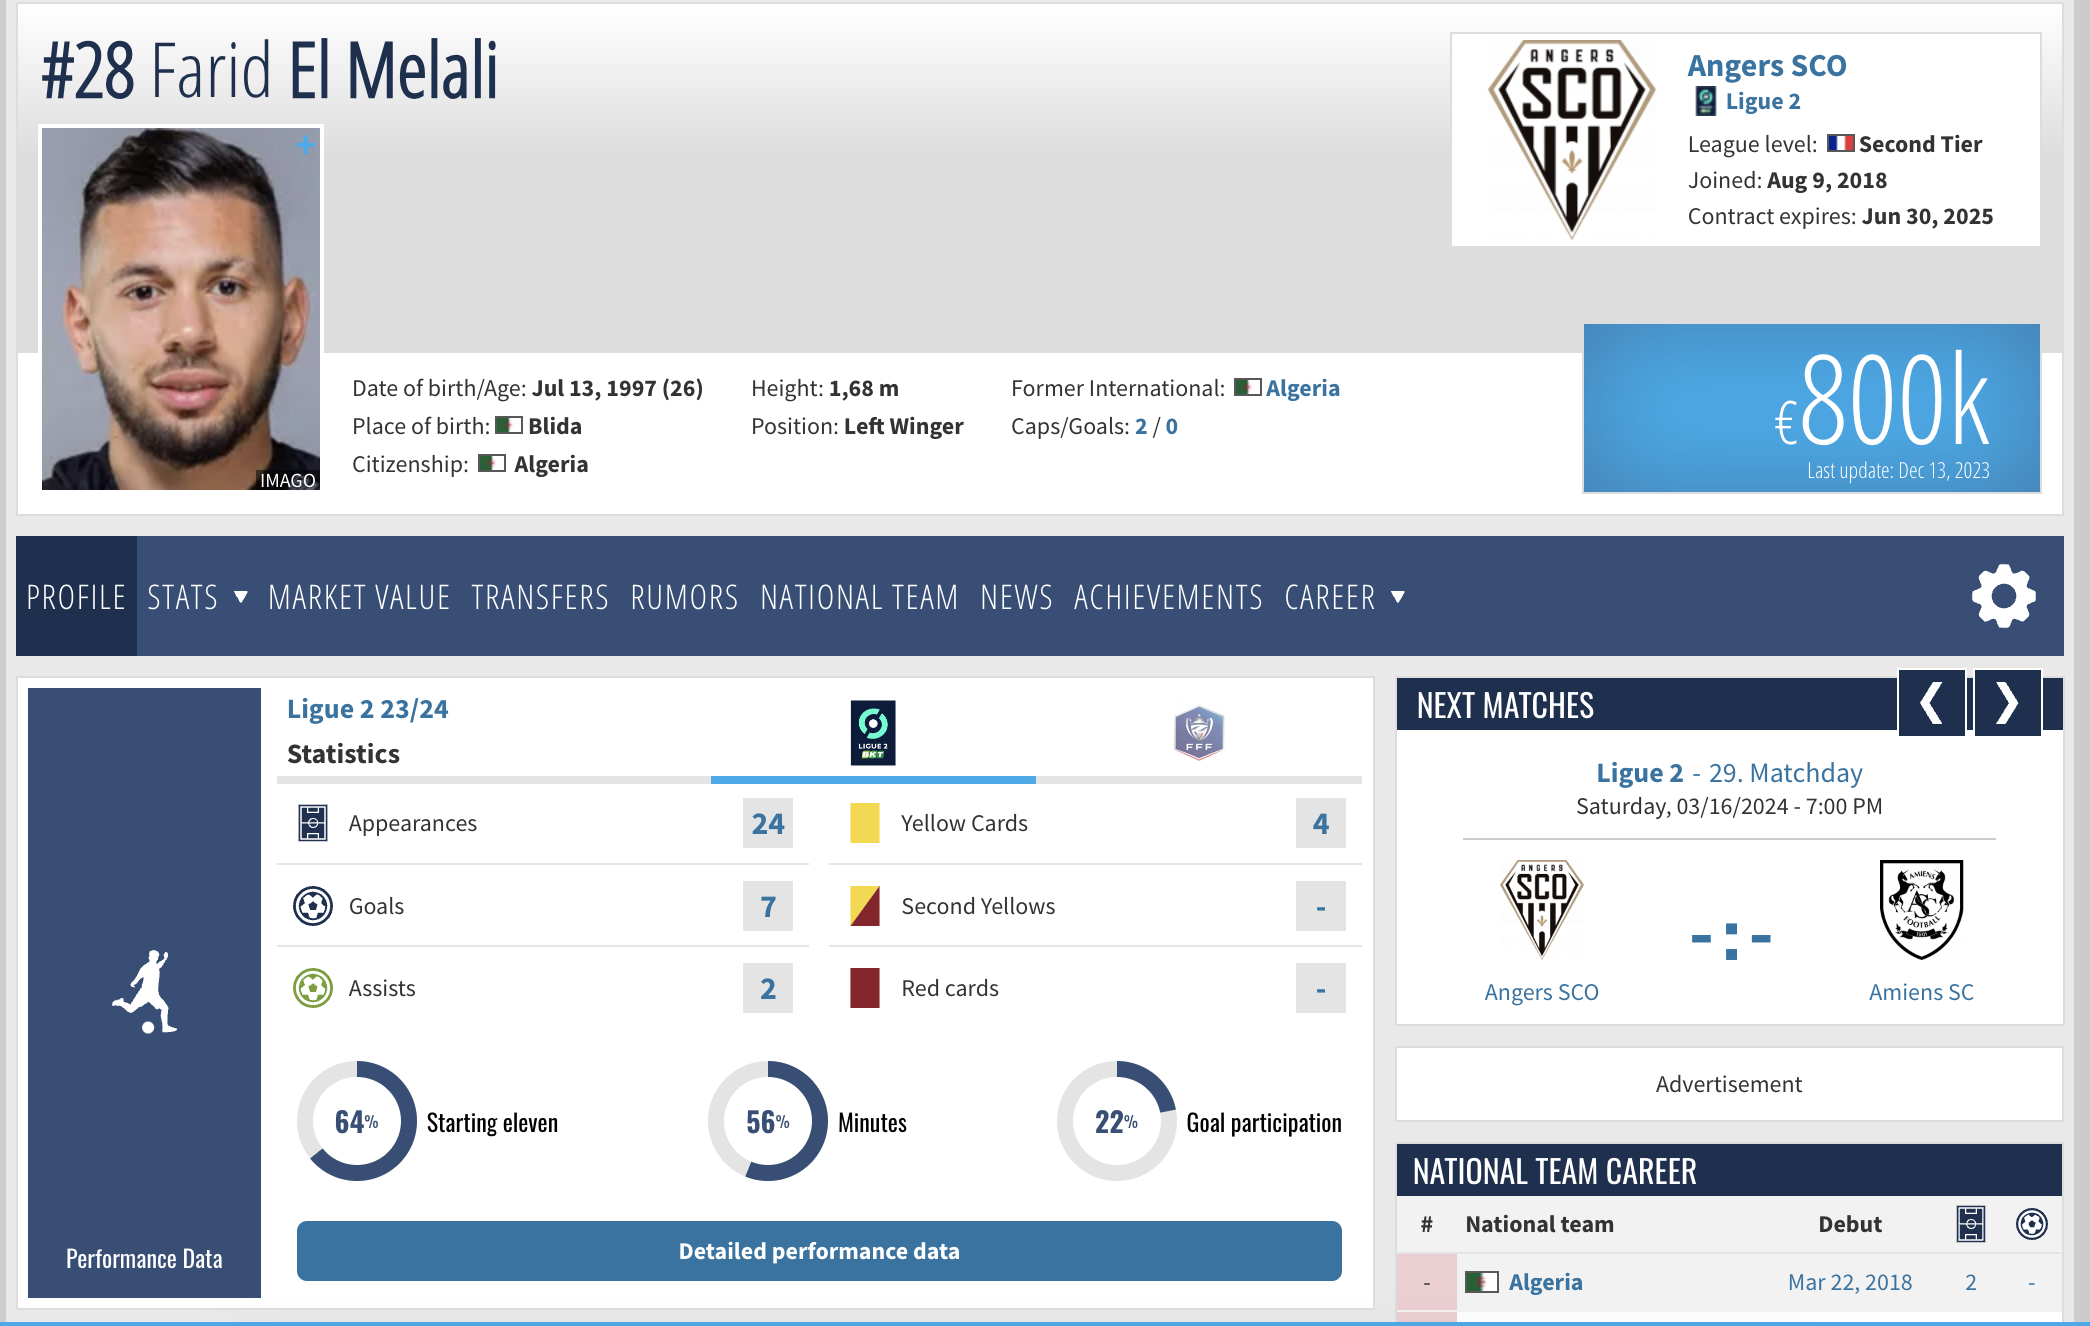

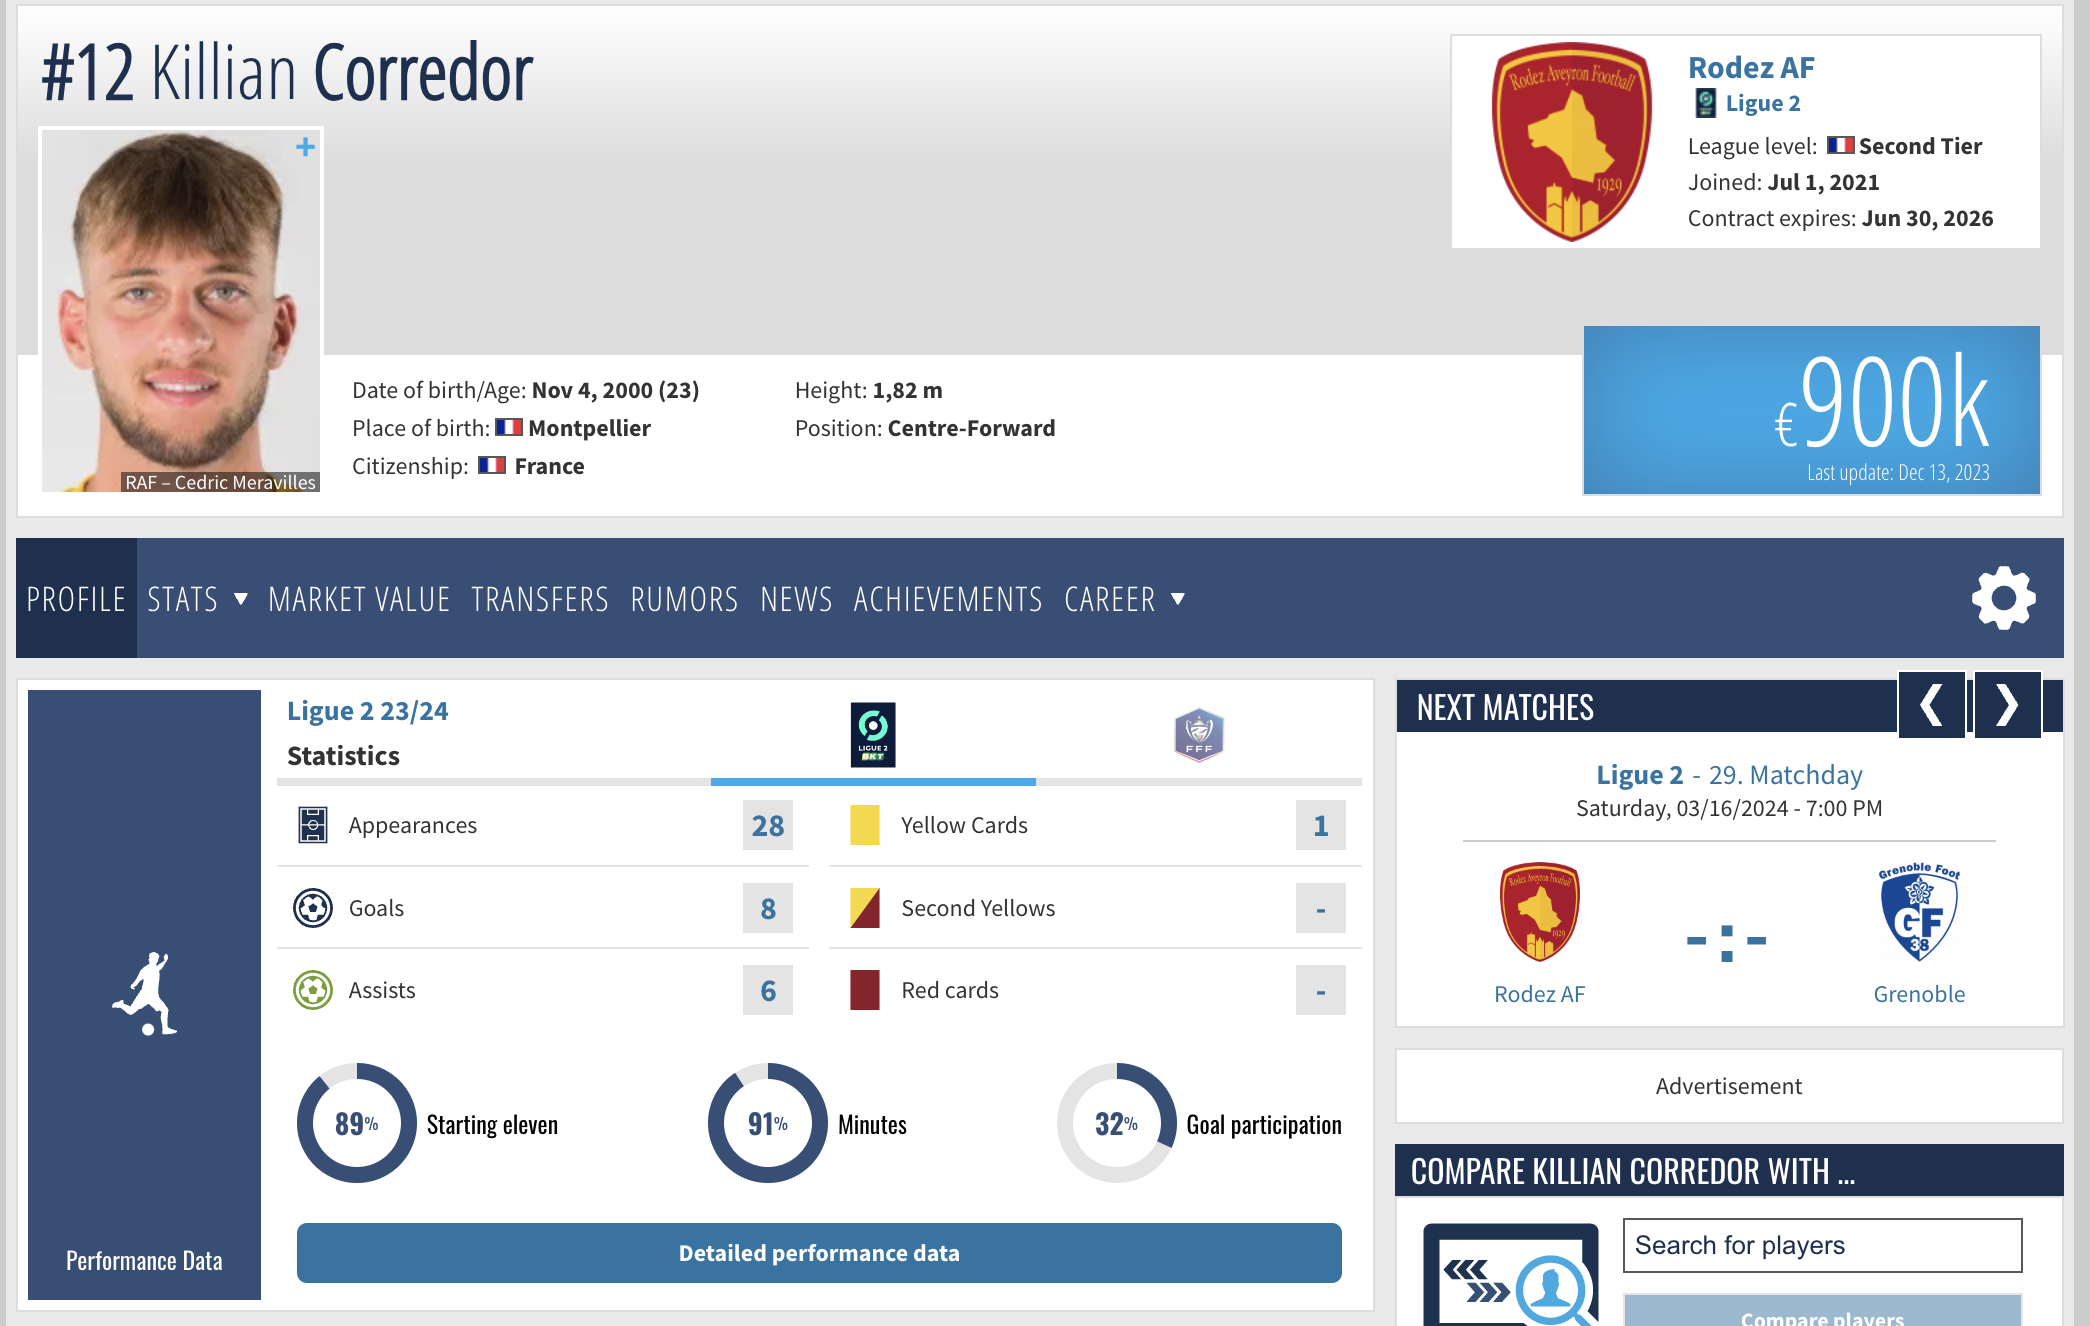

### **6. Conclusion**

Using Spark MLLIB have been able to gather some insights using regression to discover some hidden football gems that I hope get more popular with the years to come. 

1. Using API-football.com we were able to extract all the statistics from this season 23/24, for almost 15 leagues.
2. We scrapped with BS4 the page of Transfermarkt to get all the player valuations.
3. Merged both 1. and 2. to get a consolidated dataset, with the stats AND valuations.
4. Used the historical rating column to build 4 regression models based on position
5. Predict if a given player was overvalued or undervalued based on current season stats. 
6. If undervalued, looking at cost we were able to find two astounishing attackers that were very cheap, and should be advancing in their careers

Next Steps & Challenges.
1. We would love to focus more on getting stats from third division leagues where the API lacked the information. We cannot predict ratings or prices without statistics/data. 
2. Explore further MLLIB to check if a exponential model is more approapiate, in order to not use historical rating and use the Transfermarkt valuation directly. 

This could develop into a fenomenal scouting practice